# Time Series Forecast - Police Stops

## Libraries

In [5]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

In [17]:
%store -r diff_ripa
%store -r ripa_stops_df_cleaned
%store -r ripa_stops_ts 

%store -r ripa_stops_log 
%store -r decom_ripa 
%store -r trend_ripa_stops 
%store -r season_ripa_stops 
%store -r resid_ripa_stops 
%store -r ripa_stops_m



# Autocorrelation Function and Partial Autocorrelation Function

In [18]:
acf_ripa_stops = acf(diff_ripa, nlags=20, fft=False)
pacf_ripa_stops = pacf(diff_ripa, nlags=20, method='ols')

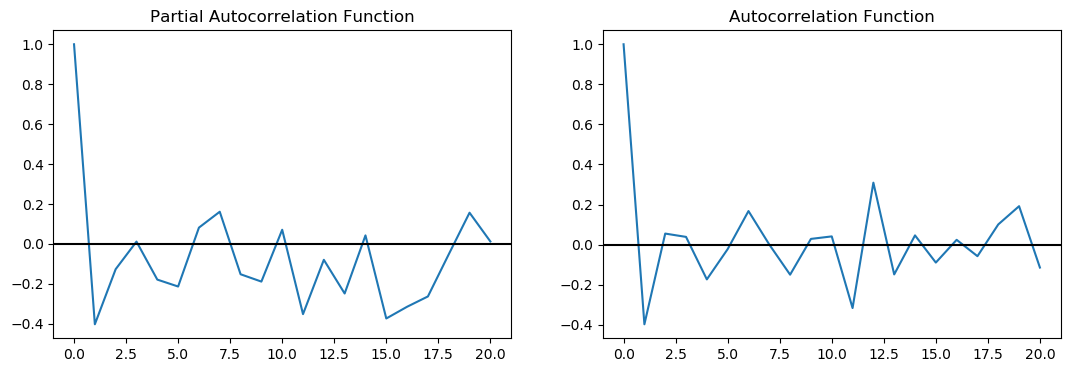

In [20]:
# Plotting PACF

f = plt.figure()
f.set_figwidth(13)
f.set_figheight(4)




plt.subplot(121)
plt.plot(pacf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Partial Autocorrelation Function")

# Plotting ACF

plt.subplot(122)
plt.plot(acf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Autocorrelation Function")

plt.show()

# Split Dataset for Training, Testing, and Validation

In [22]:
# training 80%, testing 20%

total = len(ripa_stops_ts)
#print("Total Amount: ", total)

# training set
ripa_stops_train = ripa_stops_ts[  :int(len(ripa_stops_ts)*0.8)]

# testing set
ripa_stops_test = ripa_stops_ts[  int(len(ripa_stops_ts)*0.8) : ]




#print("ripa_training_set: ", ripa_stops_train.shape)
#print("ripa_testing_set: ", ripa_stops_test.shape)

Total Amount:  54
ripa_training_set:  (43,)
ripa_testing_set:  (11,)


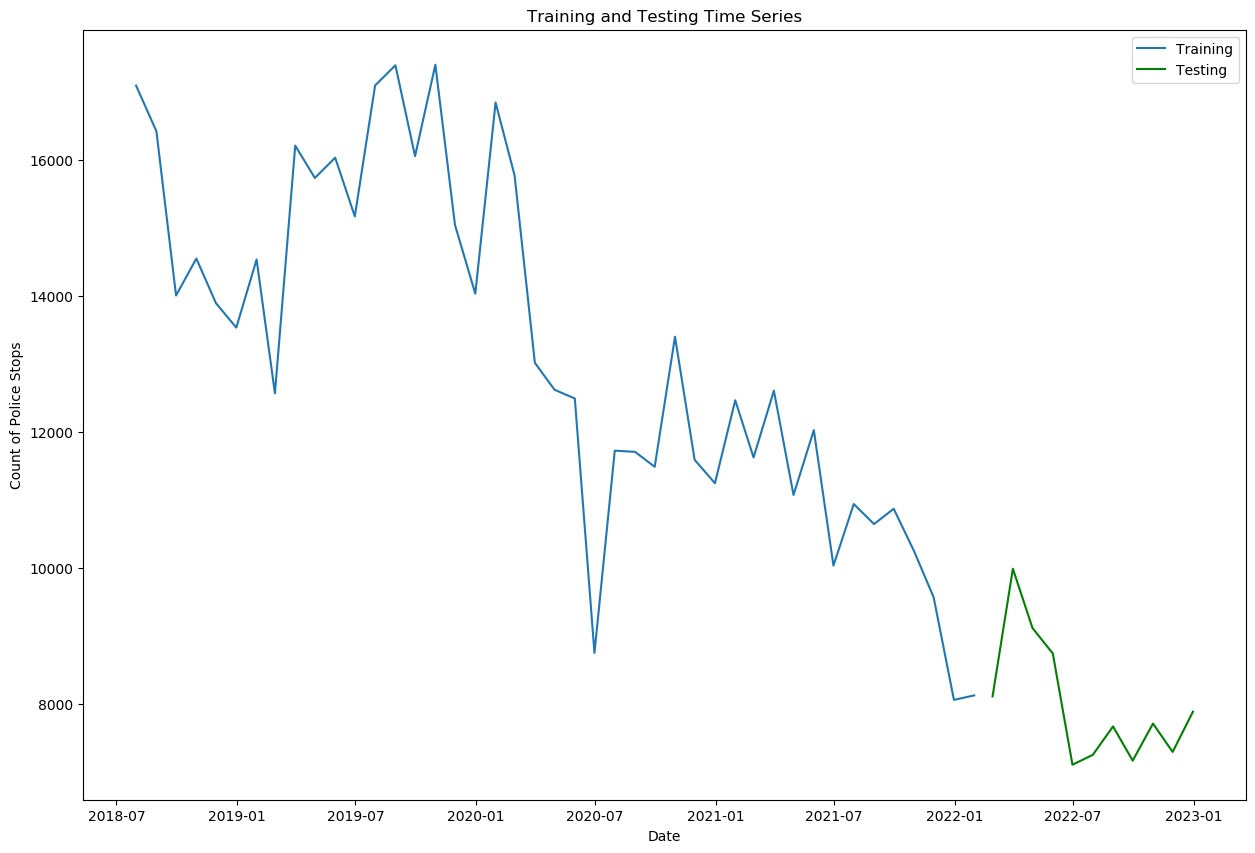

In [25]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


plt.plot(ripa_stops_train)
plt.plot(ripa_stops_test, color='green')

plt.title("Training and Testing Time Series")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.legend(['Training', 'Testing'])
plt.show()

## ARIMA Model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


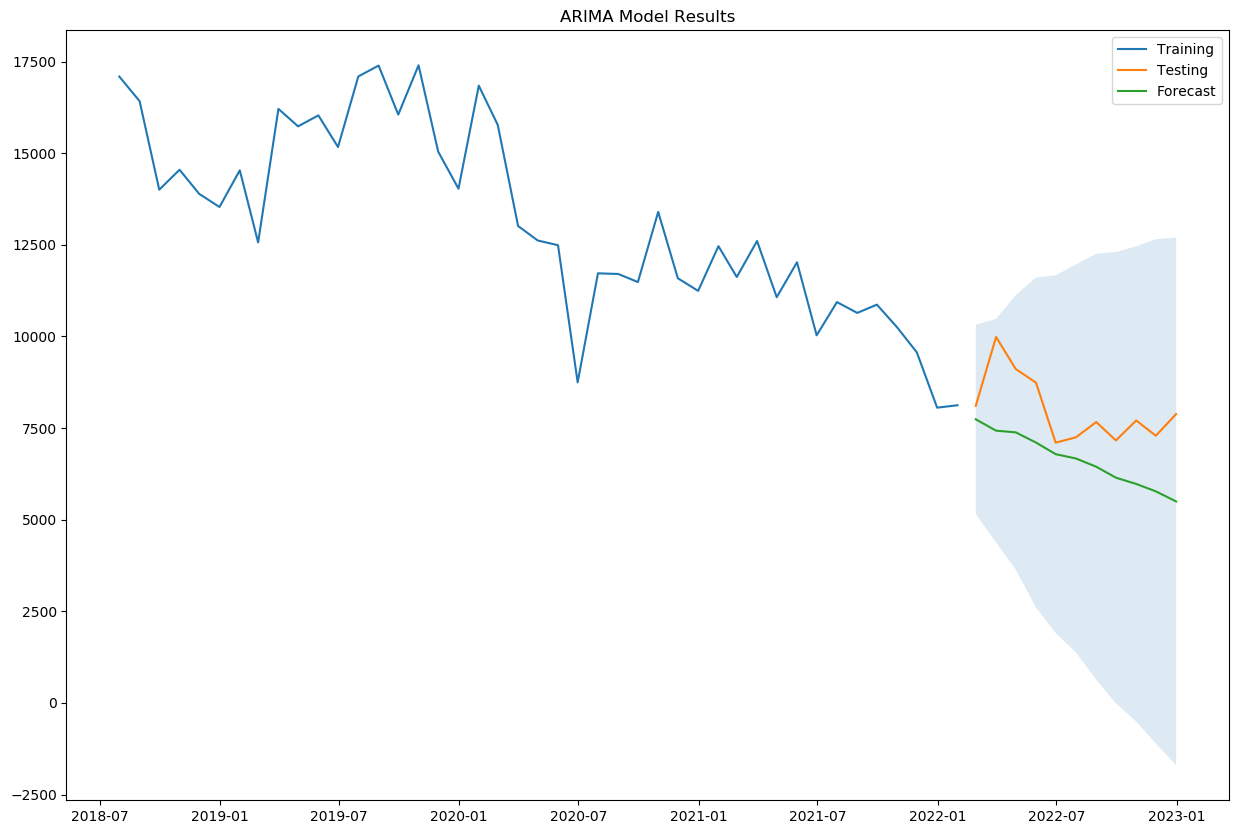

In [31]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

arima_model = ARIMA(ripa_stops_train, order = (2,1,2))
arima_output = arima_model.fit(disp=-1)
#plt.plot(diff_ripa)
#plt.plot(arima_output.fittedvalues, color="orange", label = "ARIMA Results")
#arima_output.plot_predict(dynamic = False)


forecast, series, confidence = arima_output.forecast(11, alpha = 0.05)

forecast_s = pd.Series(forecast, index = ripa_stops_test.index)
low_bound = pd.Series(confidence[: , 0], index = ripa_stops_test.index)
high_bound = pd.Series(confidence[: , 1], index = ripa_stops_test.index)


plt.plot( ripa_stops_train)
plt.plot( ripa_stops_test)
plt.plot( forecast_s)
plt.fill_between(low_bound.index, low_bound, high_bound, alpha = .15)


plt.legend(["Training", "Testing", "Forecast"])
plt.title("ARIMA Model Results")
plt.show()


In [28]:
print(arima_output.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                   42
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -361.657
Method:                       css-mle   S.D. of innovations           1316.847
Date:                Sat, 08 Apr 2023   AIC                            735.314
Time:                        07:44:04   BIC                            745.740
Sample:                    08-31-2018   HQIC                           739.136
                         - 01-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -222.9632    169.353     -1.317      0.188    -554.888     108.962
ar.L1.D.count    -0.6738      0.260     -2.594      0.009      -1.183      -0.165
ar.L2.D.count    -0.7375      0.153     

## AR Model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


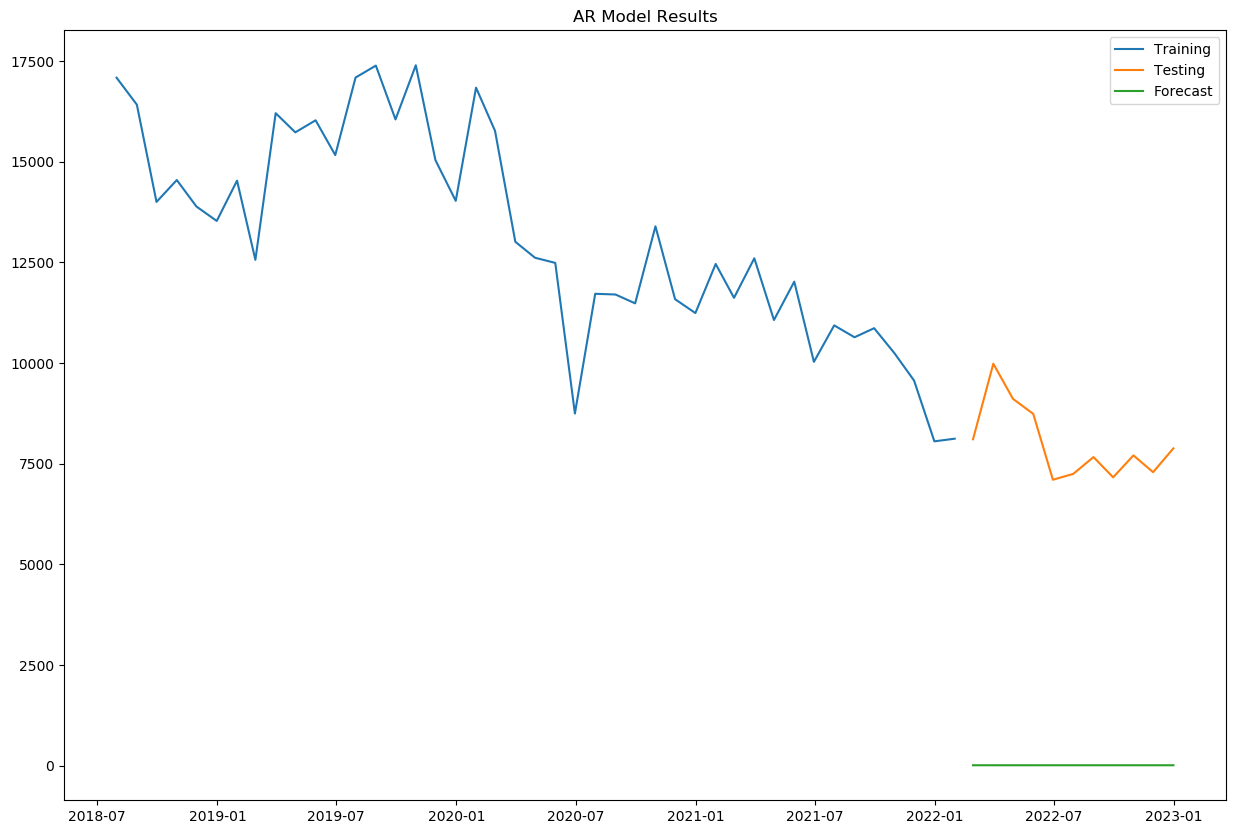

In [34]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

ar_model = ARIMA(ripa_stops_log, order = (2,1,0))
ar_output = ar_model.fit(disp=-1)

#plt.plot(diff_ripa)
#plt.plot(ar_output.fittedvalues, color="red", label = "AR Results")
#plt.legend()
#plt.title("AR Model Results")
#plt.show()



forecast, series, confidence = ar_output.forecast(11, alpha = 0.05)

forecast_s = pd.Series(forecast, index = ripa_stops_test.index)
low_bound = pd.Series(confidence[: , 0], index = ripa_stops_test.index)
high_bound = pd.Series(confidence[: , 1], index = ripa_stops_test.index)


plt.plot( ripa_stops_train)
plt.plot( ripa_stops_test)
plt.plot( forecast_s)
plt.fill_between(low_bound.index, low_bound, high_bound, alpha = .15)


plt.legend(["Training", "Testing", "Forecast"])
plt.title("AR Model Results")
plt.show()

In [33]:
print(ar_output.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                   53
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  42.719
Method:                       css-mle   S.D. of innovations              0.108
Date:                Sat, 08 Apr 2023   AIC                            -77.439
Time:                        07:58:34   BIC                            -69.558
Sample:                    08-31-2018   HQIC                           -74.408
                         - 12-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0148      0.009     -1.558      0.119      -0.033       0.004
ar.L1.D.count    -0.4472      0.136     -3.279      0.001      -0.715      -0.180
ar.L2.D.count    -0.1268      0.137     

## MA Model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


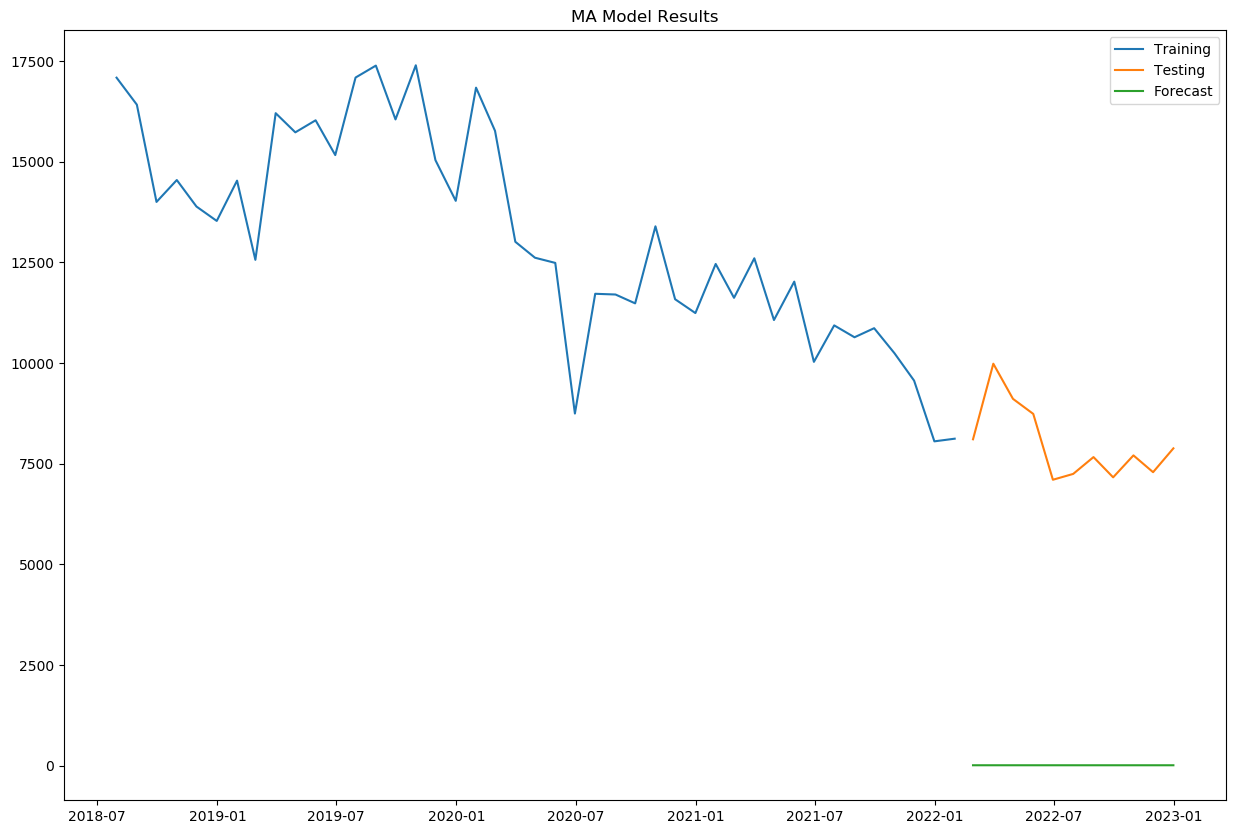

In [35]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
 
ma_model = ARIMA(ripa_stops_log, order = (0,1,2))
ma_output = ma_model.fit(disp=-1)


#plt.plot(diff_ripa)
#plt.plot(ma_output.fittedvalues, color="green", label = "MA Results")
#plt.legend()
#plt.title("MA Model Results")
#plt.show()


forecast, series, confidence = ma_output.forecast(11, alpha = 0.05)

forecast_s = pd.Series(forecast, index = ripa_stops_test.index)
low_bound = pd.Series(confidence[: , 0], index = ripa_stops_test.index)
high_bound = pd.Series(confidence[: , 1], index = ripa_stops_test.index)


plt.plot( ripa_stops_train)
plt.plot( ripa_stops_test)
plt.plot( forecast_s)
plt.fill_between(low_bound.index, low_bound, high_bound, alpha = .15)


plt.legend(["Training", "Testing", "Forecast"])
plt.title("MA Model Results")
plt.show()

In [36]:
print(ma_output.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                   53
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  42.894
Method:                       css-mle   S.D. of innovations              0.107
Date:                Sat, 08 Apr 2023   AIC                            -77.788
Time:                        08:09:10   BIC                            -69.907
Sample:                    08-31-2018   HQIC                           -74.758
                         - 12-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0146      0.008     -1.888      0.059      -0.030       0.001
ma.L1.D.count    -0.4693      0.136     -3.444      0.001      -0.736      -0.202
ma.L2.D.count    -0.0155      0.153     

# RSS Values of ARIMA Models

In [ ]:
# RSS Values

print("RSS Values")
print("ARIMA Model:",  sum( (arima_output.fittedvalues - diff_ripa)**2))
print("AR Model:",  sum( (ar_output.fittedvalues - diff_ripa)**2))
print("MA Model:",  sum( (ma_output.fittedvalues - diff_ripa)**2))

# RMSE Values of ARIMA Models

In [ ]:
 # RMSE Values  